In [ ]:
import PIL
from torchvision import transforms
import os
from torch.utils.data import DataLoader
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2
import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pytorch_lightning --quiet
import pytorch_lightning
from pytorch_lightning import LightningModule, Trainer

pytorch_lightning.utilities.seed.seed_everything(seed=123)

     |████████████████████████████████| 819kB 29.5MB/s 
     |████████████████████████████████| 235kB 29.4MB/s 
     |████████████████████████████████| 122kB 58.7MB/s 
     |████████████████████████████████| 645kB 41.8MB/s 
     |████████████████████████████████| 10.6MB 50.2MB/s 
     |████████████████████████████████| 829kB 29.5MB/s 
     |████████████████████████████████| 1.3MB 36.2MB/s 
     |████████████████████████████████| 143kB 53.9MB/s 
     |████████████████████████████████| 296kB 59.5MB/s 
ERROR: tensorflow 2.5.0 has requirement tensorboard~=2.5, but you'll have tensorboard 2.4.1 which is incompatible.


Global seed set to 123


123

# Pre-processing

## Dataset Class

*   The following Dataset class loads the data into memory;
*   As the images may be resized, a masked_fill is used for the segmentation map in order to ensure only 0 or 1 values.



In [ ]:
class TrainingDataset(torch.utils.data.Dataset):

    def __init__(self, files, transform, common_transform):    
        img = []
        img_y = []
        path = '/content/drive/MyDrive/Doutorado/Disciplinas/[IA376-I] Introdução a Deep Learning/Projeto Final/dataset/'
        for file in files:
            img_carregada = PIL.Image.open(path + file + '.png')
            img_grayscale = PIL.ImageOps.grayscale(img_carregada)
            img.append(img_grayscale)
            img_y.append(PIL.Image.open(path + file + '_seg.png'))

        self.images = img
        self.labels = img_y
        self.transform = transform
        self.common_transform = common_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = transforms.ToTensor()(self.images[idx])
        img = img.tile((3,1,1))
        label = transforms.ToTensor()(self.labels[idx])

        img_label = torch.vstack((img,label))
        img_label = self.common_transform(img_label)
        
        img = img_label[[0,1,2]]
        label = img_label[[3]]

        label = label.masked_fill(label > 0.5, 1)
        label = label.masked_fill(label < 0.5, 0)

        img = self.transform(img)

        return img, label

In [ ]:
def dnorm(x, mu, st):
  return x*st + mu

## List of files

In [ ]:
train_id = np.load('/content/drive/MyDrive/Doutorado/Disciplinas/[IA376-I] Introdução a Deep Learning/Projeto Final/train_id.npy')
val_id = np.load('/content/drive/MyDrive/Doutorado/Disciplinas/[IA376-I] Introdução a Deep Learning/Projeto Final/val_id.npy')
test_id = np.load('/content/drive/MyDrive/Doutorado/Disciplinas/[IA376-I] Introdução a Deep Learning/Projeto Final/test_id.npy')

print(f'Training samples: {len(train_id)}')
print(f'Validation samples: {len(val_id)}')
print(f'Test samples: {len(test_id)}')

Training samples: 234
Validation samples: 58
Test samples: 96


## Getting the mean and standard dev. of the training data

In [ ]:
size = (512,512)

In [ ]:
transform_train_noaugment = transforms.Compose([
                                               ])

common_transform_train_noaugment = transforms.Compose([
                                                    transforms.Resize(size),
                                                    ])

train_dataset_noaugment = TrainingDataset(files = train_id,
                                          transform = transform_train_noaugment,
                                          common_transform = common_transform_train_noaugment)

Calculating the mean & std:

In [ ]:
out = []
for k in range(len(train_dataset_noaugment)):
    xt,_ = train_dataset_noaugment[k]
    out.append(xt)

train_mean = torch.mean(torch.stack(out).squeeze(), dim=(0,1,2,3))
train_std = torch.std(torch.stack(out).squeeze(), dim=(0,1,2,3))

print(train_mean, train_std)

tensor(0.1908) tensor(0.2501)


Deleting the dataset

In [ ]:
del train_dataset_noaugment

## Instantiating the Datasets

Training dataset:

In [ ]:
transform_train = transforms.Compose([
                                      transforms.Normalize(mean=train_mean, std=train_std),
                                    ])

common_transform_train = transforms.Compose([
                                            transforms.RandomRotation(30),
                                            transforms.RandomResizedCrop(size=size, scale=(0.8, 1.0)),
                                            transforms.RandomHorizontalFlip(),
                                            transforms.RandomVerticalFlip(),
                                    ])

train_dataset = TrainingDataset(files = train_id,
                                transform = transform_train,
                                common_transform = common_transform_train)

Validation and testing dataset:

In [ ]:
transform_test = transforms.Compose([
                                      transforms.Normalize(mean=train_mean, std=train_std)
                                    ])

common_transform_test = transforms.Compose([
                                            transforms.Resize(size=size),
                                    ])

# datasets
val_dataset = TrainingDataset(files = val_id,
                                transform = transform_test,
                                common_transform = common_transform_test)

test_dataset = TrainingDataset(files = test_id,
                                transform = transform_test,
                                common_transform = common_transform_test)

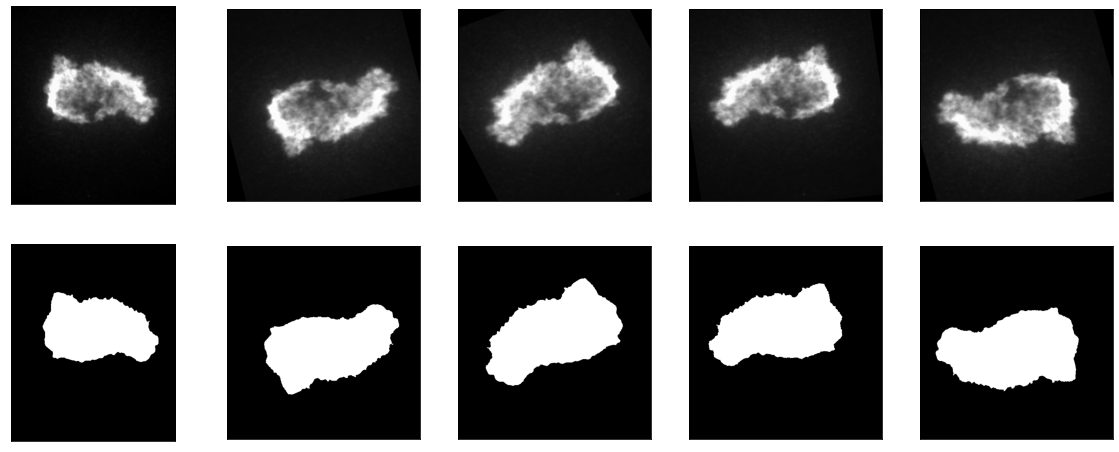

In [ ]:
plt.figure(figsize=(20,8))

idx = 20

plt.subplot(2,5,1)
plt.imshow(np.array(train_dataset.images[idx]), cmap='gray')
plt.xticks([]);
plt.yticks([]);

plt.subplot(2,5,6)
plt.imshow(np.array(train_dataset.labels[idx]), cmap='gray')
plt.xticks([]);
plt.yticks([]);

for k in range(1,5):
    xt, yt = train_dataset[idx]

    plt.subplot(2,5,k+1)
    plt.imshow(xt[0], cmap='gray')
    plt.xticks([]);
    plt.yticks([]);

    plt.subplot(2,5,5+k+1)
    plt.imshow(yt[0], cmap='gray')
    plt.xticks([]);
    plt.yticks([]);

plt.savefig('exemplo_augment.eps', format='eps')

In [ ]:
x_train, y_train = train_dataset[60]
x_val, y_val = val_dataset[10]
x_test, y_test = test_dataset[30]

print(x_train.shape, y_train.shape, len(train_dataset))
print(x_val.shape, y_val.shape, len(val_dataset))
print(x_test.shape, y_test.shape, len(test_dataset))

torch.Size([3, 512, 512]) torch.Size([1, 512, 512]) 234
torch.Size([3, 512, 512]) torch.Size([1, 512, 512]) 58
torch.Size([3, 512, 512]) torch.Size([1, 512, 512]) 96


## Instantiating th Dataloader

In [ ]:
batch_size = 2

In [ ]:
train_dataloader = DataLoader(train_dataset,
                              batch_size = batch_size,
                              shuffle = True)

val_dataloader = DataLoader(val_dataset,
                              batch_size = batch_size,
                              shuffle = False)

test_dataloader = DataLoader(test_dataset,
                              batch_size = batch_size,
                              shuffle = False)

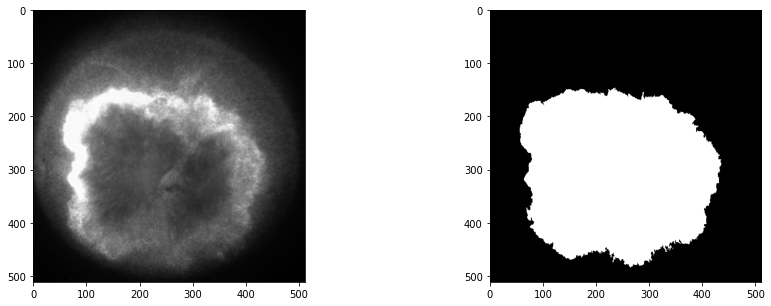

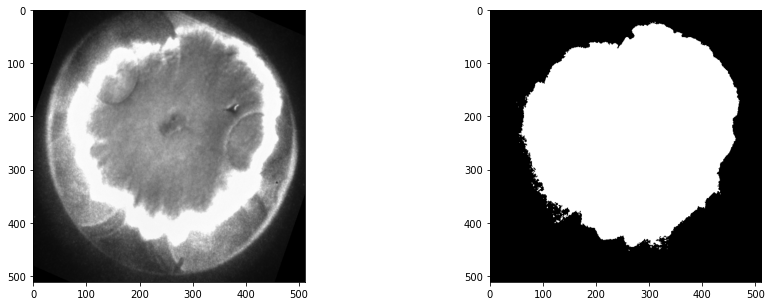

In [ ]:
xt, yt = next(iter(train_dataloader))

for k in range(batch_size):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.imshow(dnorm(xt[k,0], train_mean, train_std), cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(yt[k,0], cmap='gray')

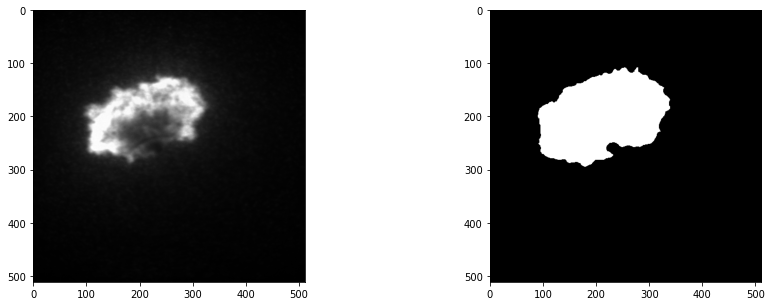

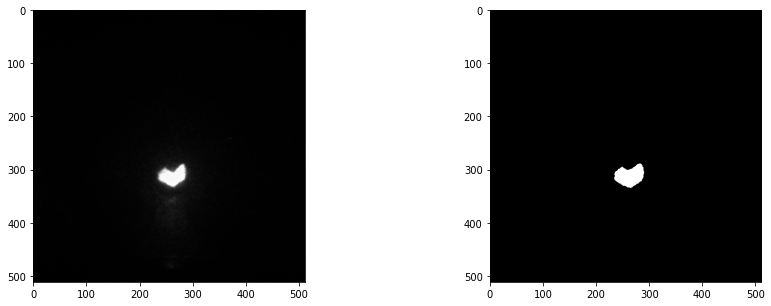

In [ ]:
xt, yt = next(iter(test_dataloader))

for k in range(batch_size):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.imshow(dnorm(xt[k,0], train_mean, train_std), cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(yt[k,0], cmap='gray')

## HRNet

In [ ]:
import logging
import functools

import numpy as np

import torch
import torch.nn as nn
import torch._utils
import torch.nn.functional as F

BatchNorm2d = nn.BatchNorm2d

BN_MOMENTUM = 0.01
logger = logging.getLogger(__name__)

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=False)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out = out + residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1,
                               bias=False)
        self.bn3 = BatchNorm2d(planes * self.expansion,
                               momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=False)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out = out + residual
        out = self.relu(out)

        return out


class HighResolutionModule(nn.Module):
    def __init__(self, num_branches, blocks, num_blocks, num_inchannels,
                 num_channels, fuse_method, multi_scale_output=True):
        super(HighResolutionModule, self).__init__()
        self._check_branches(
            num_branches, blocks, num_blocks, num_inchannels, num_channels)

        self.num_inchannels = num_inchannels
        self.fuse_method = fuse_method
        self.num_branches = num_branches

        self.multi_scale_output = multi_scale_output

        self.branches = self._make_branches(
            num_branches, blocks, num_blocks, num_channels)
        self.fuse_layers = self._make_fuse_layers()
        self.relu = nn.ReLU(inplace=False)

    def _check_branches(self, num_branches, blocks, num_blocks,
                        num_inchannels, num_channels):
        if num_branches != len(num_blocks):
            error_msg = 'NUM_BRANCHES({}) <> NUM_BLOCKS({})'.format(
                num_branches, len(num_blocks))
            logger.error(error_msg)
            raise ValueError(error_msg)

        if num_branches != len(num_channels):
            error_msg = 'NUM_BRANCHES({}) <> NUM_CHANNELS({})'.format(
                num_branches, len(num_channels))
            logger.error(error_msg)
            raise ValueError(error_msg)

        if num_branches != len(num_inchannels):
            error_msg = 'NUM_BRANCHES({}) <> NUM_INCHANNELS({})'.format(
                num_branches, len(num_inchannels))
            logger.error(error_msg)
            raise ValueError(error_msg)

    def _make_one_branch(self, branch_index, block, num_blocks, num_channels,
                         stride=1):
        downsample = None
        if stride != 1 or \
           self.num_inchannels[branch_index] != num_channels[branch_index] * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.num_inchannels[branch_index],
                          num_channels[branch_index] * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                BatchNorm2d(num_channels[branch_index] * block.expansion,
                            momentum=BN_MOMENTUM),
            )

        layers = []
        layers.append(block(self.num_inchannels[branch_index],
                            num_channels[branch_index], stride, downsample))
        self.num_inchannels[branch_index] = \
            num_channels[branch_index] * block.expansion
        for i in range(1, num_blocks[branch_index]):
            layers.append(block(self.num_inchannels[branch_index],
                                num_channels[branch_index]))

        return nn.Sequential(*layers)

    def _make_branches(self, num_branches, block, num_blocks, num_channels):
        branches = []

        for i in range(num_branches):
            branches.append(
                self._make_one_branch(i, block, num_blocks, num_channels))

        return nn.ModuleList(branches)

    def _make_fuse_layers(self):
        if self.num_branches == 1:
            return None

        num_branches = self.num_branches
        num_inchannels = self.num_inchannels
        fuse_layers = []
        for i in range(num_branches if self.multi_scale_output else 1):
            fuse_layer = []
            for j in range(num_branches):
                if j > i:
                    fuse_layer.append(nn.Sequential(
                        nn.Conv2d(num_inchannels[j],
                                  num_inchannels[i],
                                  1,
                                  1,
                                  0,
                                  bias=False),
                        BatchNorm2d(num_inchannels[i], momentum=BN_MOMENTUM)))
                elif j == i:
                    fuse_layer.append(None)
                else:
                    conv3x3s = []
                    for k in range(i-j):
                        if k == i - j - 1:
                            num_outchannels_conv3x3 = num_inchannels[i]
                            conv3x3s.append(nn.Sequential(
                                nn.Conv2d(num_inchannels[j],
                                          num_outchannels_conv3x3,
                                          3, 2, 1, bias=False),
                                BatchNorm2d(num_outchannels_conv3x3, 
                                            momentum=BN_MOMENTUM)))
                        else:
                            num_outchannels_conv3x3 = num_inchannels[j]
                            conv3x3s.append(nn.Sequential(
                                nn.Conv2d(num_inchannels[j],
                                          num_outchannels_conv3x3,
                                          3, 2, 1, bias=False),
                                BatchNorm2d(num_outchannels_conv3x3,
                                            momentum=BN_MOMENTUM),
                                nn.ReLU(inplace=False)))
                    fuse_layer.append(nn.Sequential(*conv3x3s))
            fuse_layers.append(nn.ModuleList(fuse_layer))

        return nn.ModuleList(fuse_layers)

    def get_num_inchannels(self):
        return self.num_inchannels

    def forward(self, x):
        if self.num_branches == 1:
            return [self.branches[0](x[0])]

        for i in range(self.num_branches):
            x[i] = self.branches[i](x[i])

        x_fuse = []
        for i in range(len(self.fuse_layers)):
            y = x[0] if i == 0 else self.fuse_layers[i][0](x[0])
            for j in range(1, self.num_branches):
                if i == j:
                    y = y + x[j]
                elif j > i:
                    width_output = x[i].shape[-1]
                    height_output = x[i].shape[-2]
                    y = y + F.interpolate(
                        self.fuse_layers[i][j](x[j]),
                        size=[height_output, width_output],
                        mode='bilinear')
                else:
                    y = y + self.fuse_layers[i][j](x[j])
            x_fuse.append(self.relu(y))

        return x_fuse


blocks_dict = {
    'BASIC': BasicBlock,
    'BOTTLENECK': Bottleneck
}


class HighResolutionNet(nn.Module):

    def __init__(self, config, **kwargs):
        #extra = config.MODEL.EXTRA
        extra = config['MODEL']['EXTRA']
        super(HighResolutionNet, self).__init__()

        # stem net
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn1 = BatchNorm2d(64, momentum=BN_MOMENTUM)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn2 = BatchNorm2d(64, momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=False)

        self.stage1_cfg = extra['STAGE1']
        num_channels = self.stage1_cfg['NUM_CHANNELS'][0]
        block = blocks_dict[self.stage1_cfg['BLOCK']]
        num_blocks = self.stage1_cfg['NUM_BLOCKS'][0]
        self.layer1 = self._make_layer(block, 64, num_channels, num_blocks)
        stage1_out_channel = block.expansion*num_channels

        self.stage2_cfg = extra['STAGE2']
        num_channels = self.stage2_cfg['NUM_CHANNELS']
        block = blocks_dict[self.stage2_cfg['BLOCK']]
        num_channels = [
            num_channels[i] * block.expansion for i in range(len(num_channels))]
        self.transition1 = self._make_transition_layer(
            [stage1_out_channel], num_channels)
        self.stage2, pre_stage_channels = self._make_stage(
            self.stage2_cfg, num_channels)

        self.stage3_cfg = extra['STAGE3']
        num_channels = self.stage3_cfg['NUM_CHANNELS']
        block = blocks_dict[self.stage3_cfg['BLOCK']]
        num_channels = [
            num_channels[i] * block.expansion for i in range(len(num_channels))]
        self.transition2 = self._make_transition_layer(
            pre_stage_channels, num_channels)
        self.stage3, pre_stage_channels = self._make_stage(
            self.stage3_cfg, num_channels)

        self.stage4_cfg = extra['STAGE4']
        num_channels = self.stage4_cfg['NUM_CHANNELS']
        block = blocks_dict[self.stage4_cfg['BLOCK']]
        num_channels = [
            num_channels[i] * block.expansion for i in range(len(num_channels))]
        self.transition3 = self._make_transition_layer(
            pre_stage_channels, num_channels)
        self.stage4, pre_stage_channels = self._make_stage(
            self.stage4_cfg, num_channels, multi_scale_output=True)
        
        last_inp_channels = np.int(np.sum(pre_stage_channels))

        self.last_layer = nn.Sequential(
            nn.Conv2d(
                in_channels=last_inp_channels,
                out_channels=last_inp_channels,
                kernel_size=1,
                stride=1,
                padding=0),
            BatchNorm2d(last_inp_channels, momentum=BN_MOMENTUM),
            nn.ReLU(inplace=False),
            nn.Conv2d(
                in_channels=last_inp_channels,
                out_channels=config['NUM_CLASSES'],
                kernel_size=extra['FINAL_CONV_KERNEL'],
                stride=1,
                padding=1 if extra['FINAL_CONV_KERNEL'] == 3 else 0)
        )

    def _make_transition_layer(
            self, num_channels_pre_layer, num_channels_cur_layer):
        num_branches_cur = len(num_channels_cur_layer)
        num_branches_pre = len(num_channels_pre_layer)

        transition_layers = []
        for i in range(num_branches_cur):
            if i < num_branches_pre:
                if num_channels_cur_layer[i] != num_channels_pre_layer[i]:
                    transition_layers.append(nn.Sequential(
                        nn.Conv2d(num_channels_pre_layer[i],
                                  num_channels_cur_layer[i],
                                  3,
                                  1,
                                  1,
                                  bias=False),
                        BatchNorm2d(
                            num_channels_cur_layer[i], momentum=BN_MOMENTUM),
                        nn.ReLU(inplace=False)))
                else:
                    transition_layers.append(None)
            else:
                conv3x3s = []
                for j in range(i+1-num_branches_pre):
                    inchannels = num_channels_pre_layer[-1]
                    outchannels = num_channels_cur_layer[i] \
                        if j == i-num_branches_pre else inchannels
                    conv3x3s.append(nn.Sequential(
                        nn.Conv2d(
                            inchannels, outchannels, 3, 2, 1, bias=False),
                        BatchNorm2d(outchannels, momentum=BN_MOMENTUM),
                        nn.ReLU(inplace=False)))
                transition_layers.append(nn.Sequential(*conv3x3s))

        return nn.ModuleList(transition_layers)

    def _make_layer(self, block, inplanes, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                BatchNorm2d(planes * block.expansion, momentum=BN_MOMENTUM),
            )

        layers = []
        layers.append(block(inplanes, planes, stride, downsample))
        inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(inplanes, planes))

        return nn.Sequential(*layers)

    def _make_stage(self, layer_config, num_inchannels,
                    multi_scale_output=True):
        num_modules = layer_config['NUM_MODULES']
        num_branches = layer_config['NUM_BRANCHES']
        num_blocks = layer_config['NUM_BLOCKS']
        num_channels = layer_config['NUM_CHANNELS']
        block = blocks_dict[layer_config['BLOCK']]
        fuse_method = layer_config['FUSE_METHOD']

        modules = []
        for i in range(num_modules):
            if not multi_scale_output and i == num_modules - 1:
                reset_multi_scale_output = False
            else:
                reset_multi_scale_output = True
            modules.append(
                HighResolutionModule(num_branches,
                                      block,
                                      num_blocks,
                                      num_inchannels,
                                      num_channels,
                                      fuse_method,
                                      reset_multi_scale_output)
            )
            num_inchannels = modules[-1].get_num_inchannels()

        return nn.Sequential(*modules), num_inchannels

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        #print(x.shape)
        x = self.layer1(x)
        #print(x.shape)
        x_list = []
        for i in range(self.stage2_cfg['NUM_BRANCHES']):
            if self.transition1[i] is not None:
                x_list.append(self.transition1[i](x))
            else:
                x_list.append(x)
        y_list = self.stage2(x_list)

        x_list = []
        for i in range(self.stage3_cfg['NUM_BRANCHES']):
            if self.transition2[i] is not None:
                if i < self.stage2_cfg['NUM_BRANCHES']:
                    x_list.append(self.transition2[i](y_list[i]))
                else:
                    x_list.append(self.transition2[i](y_list[-1]))
            else:
                x_list.append(y_list[i])
        y_list = self.stage3(x_list)

        x_list = []
        for i in range(self.stage4_cfg['NUM_BRANCHES']):
            if self.transition3[i] is not None:
                if i < self.stage3_cfg['NUM_BRANCHES']:
                    x_list.append(self.transition3[i](y_list[i]))
                else:
                    x_list.append(self.transition3[i](y_list[-1]))
            else:
                x_list.append(y_list[i])
        x = self.stage4(x_list)
        #print(x.shape)
        # Upsampling
        x0_h, x0_w = x[0].size(2), x[0].size(3)
        #x0_h, x0_w = x0_h* 4, x0_w * 2 
        #print(x0_h, x0_w)
        x1 = F.upsample(x[1], size=(x0_h, x0_w), mode='bilinear')
        x2 = F.upsample(x[2], size=(x0_h, x0_w), mode='bilinear')
        x3 = F.upsample(x[3], size=(x0_h, x0_w), mode='bilinear')

        x = torch.cat([x[0], x1, x2, x3], 1)

        x = self.last_layer(x)

        return x

    def init_weights(self, pretrained='',):
        logger.info('=> init weights from normal distribution')
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.001)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        if pretrained:
            pretrained_dict = torch.load(pretrained)
            logger.info('=> loading pretrained model {}'.format(pretrained))
            model_dict = self.state_dict()
            pretrained_dict = {k: v for k, v in pretrained_dict.items()
                               if k in model_dict.keys()}
            for k, _ in pretrained_dict.items():
                logger.info(
                    '=> loading {} pretrained model {}'.format(k, pretrained))
            model_dict.update(pretrained_dict)
            self.load_state_dict(model_dict)

def get_seg_model(cfg, **kwargs):
    model = HighResolutionNet(cfg, **kwargs)
    model.init_weights(cfg['PRETRAINED'])

    return model

## Instantiating the model

In [ ]:
config = {}

config['NUM_CLASSES'] = 2
config['PRETRAINED'] = None

config['MODEL'] = {'EXTRA': {'FINAL_CONV_KERNEL': 1,
      'STAGE1': {'BLOCK': 'BOTTLENECK', 
                 'FUSE_METHOD': 'SUM',
                 'NUM_BLOCKS': [1],
                 'NUM_CHANNELS': [32],
                 'NUM_MODULES': 1,
                 'NUM_RANCHES': 1
                },
      'STAGE2': {'BLOCK': 'BASIC',
                 'FUSE_METHOD': 'SUM',
                 'NUM_BLOCKS': [2, 2],
                 'NUM_BRANCHES': 2,
                 'NUM_CHANNELS': [16, 32],
                 'NUM_MODULES': 1
                },
      'STAGE3':{'BLOCK': 'BASIC',
                'FUSE_METHOD': 'SUM',
                'NUM_BLOCKS': [2, 2, 2],
                'NUM_BRANCHES': 3,
                'NUM_CHANNELS': [16, 32, 64],
                'NUM_MODULES': 1
               },
       'STAGE4': {'BLOCK': 'BASIC',
                 
                 'FUSE_METHOD': 'SUM',
                 'NUM_BLOCKS': [2, 2, 2, 2],
                 'NUM_BRANCHES': 4,
                 'NUM_CHANNELS': [16, 32, 64, 128],
                 'NUM_MODULES': 1
                 }}}
                 
model = get_seg_model(config)
model.train()

HighResolutionNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (relu): ReLU()
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
      (conv3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
      (relu): ReLU()
      (dow

## Loss

In [ ]:
class DiceLoss(torch.nn.Module):
    def __init__(self, smooth = 1):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, y_true, y_pred):
        # y_true: (batch_size, L, W)
        # y_pred: (batch_size, num_classes, L, W)

        num_classes = y_pred.shape[1]
        y_pred = torch.softmax(y_pred, dim=1) # probabilities for each class

        # y_pred: (batch_size, 1, L, W)
        b_size = y_pred.shape[0]

        loss = 0
        for c in range(num_classes):
            pred_c = y_pred[:,c,:,:].contiguous().view(b_size,-1)
            true_c = 1*(y_true == c).contiguous().view(b_size,-1)
            inter = (pred_c * true_c).sum(axis=1)
            loss += (2 * inter + self.smooth) / (num_classes*(pred_c.sum(axis=1) + true_c.sum(axis=1) + self.smooth))
        
        # loss: (batch_size, 1)
        return 1 - loss.unsqueeze(1)

# Lightning

In [ ]:
class LightningClassifier(LightningModule):
    def __init__(self, hparams, modelo):
        super().__init__()

        self.save_hyperparameters(hparams)
        self.criterion = DiceLoss()
        self.model = modelo

        self.train_loss = []
        self.val_loss = []

    def forward(self, x):
        logits = self.model(x)
        preds = logits.argmax(dim=1)
        return logits, preds

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        logits = self.model(x)

        batch_losses = self.criterion(y, logits)

        loss = batch_losses.mean(dim=0)
        # run['train/batch_loss'].log(loss)

        return {'loss': loss, 'batch_losses': batch_losses}

    def training_epoch_end(self, outputs):
        avg_loss = torch.vstack([output['batch_losses'] for output in outputs]).mean()
        self.train_loss.append(avg_loss.item())
        #run['train/loss'].log(avg_loss)
        return
  
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        logits, preds = self.forward(x)
        batch_losses = self.criterion(y, logits)
        
        return {'batch_losses': batch_losses}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.vstack([output['batch_losses'] for output in outputs]).mean()

        # run['valid/loss'].log(avg_loss)

        metrics = {'valid_loss': avg_loss.item()}
        output =  {'progress_bar': metrics, 'valid_loss': avg_loss.item()}
        self.val_loss.append(avg_loss.item())
        
        self.log('valid_loss', avg_loss.item(), prog_bar=True)

        return output
  
    def test_step(self, val_batch, batch_idx):
        x, y = val_batch
        logits, preds = self.forward(x)
        batch_losses = self.criterion(y, logits)

        return {'batch_losses': batch_losses}

    def test_epoch_end(self, outputs):
        avg_loss = torch.vstack([output['batch_losses'] for output in outputs]).mean()

        # run['valid/loss'].log(avg_loss)
        metrics = {'Test loss': avg_loss.item()}
        output =  {'progress_bar': metrics}

        self.log('test_loss', avg_loss.item())

        return output

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr = self.hparams['learning_rate'])
        scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda epoch: 0.99)
        return [optimizer], [scheduler]

In [ ]:
hparams = {
    'max_epochs': 50,
    'learning_rate': 1e-3
}

pl_model = LightningClassifier(hparams=hparams, modelo=model)

trainer = Trainer(max_epochs = hparams['max_epochs'], gpus=1)

trainer.fit(pl_model, train_dataloader, val_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | criterion | DiceLoss          | 0     
1 | model     | HighResolutionNet | 1.5 M 
------------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
6.147     Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
Global seed set to 123


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:897: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn('Detected KeyboardInterrupt, attempting graceful shutdown...')


Loss

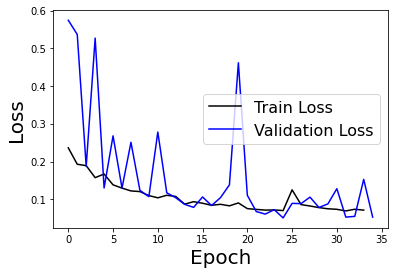

In [ ]:
plt.plot(pl_model.train_loss, color='k')
plt.plot(pl_model.val_loss, color='blue')

plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.legend(['Train Loss', 'Validation Loss'], fontsize=16)

Avaliando a saída

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


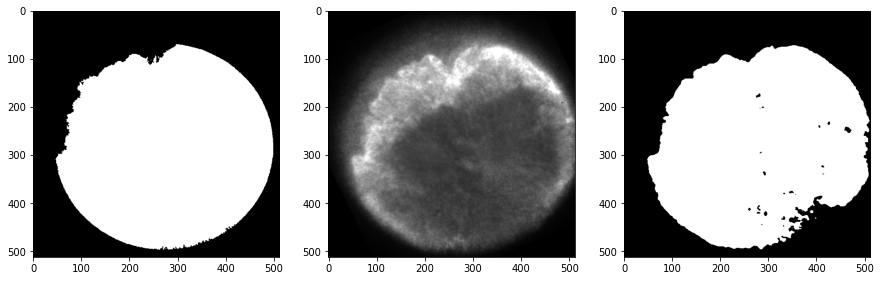

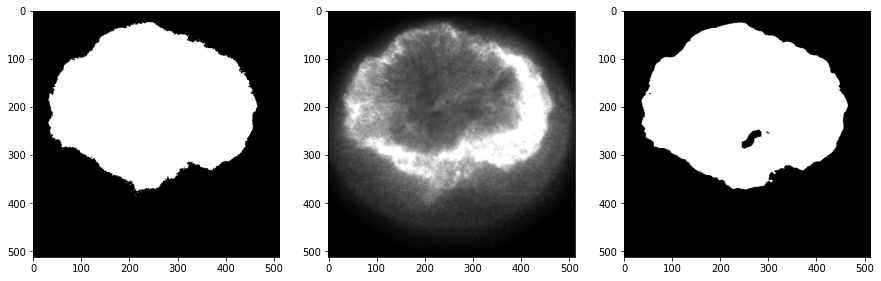

In [ ]:
x,y = next(iter(train_dataloader))

model.eval()
model.to('cuda')
with torch.no_grad():
    out = model.forward(x.to('cuda'))

outs = torch.argmax(out.to('cpu'), dim=1)

for k in range(batch_size):
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(y[k,0], cmap='gray')

    plt.subplot(1,3,2)
    plt.imshow(x[k,0], cmap='gray')

    plt.subplot(1,3,3)
    plt.imshow(np.array(outs[k]), cmap='gray')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


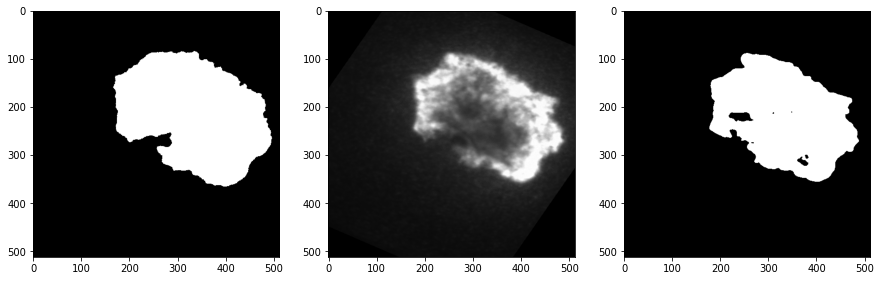

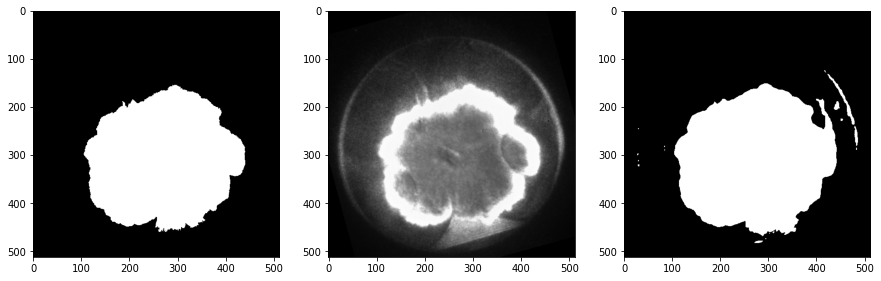

In [ ]:
x,y = next(iter(train_dataloader))

model.eval()
model.to('cuda')
with torch.no_grad():
    out = model.forward(x.to('cuda'))

outs = torch.argmax(out.to('cpu'), dim=1)

for k in range(batch_size):
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(y[k,0], cmap='gray')

    plt.subplot(1,3,2)
    plt.imshow(x[k,0], cmap='gray')

    plt.subplot(1,3,3)
    plt.imshow(np.array(outs[k]), cmap='gray')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


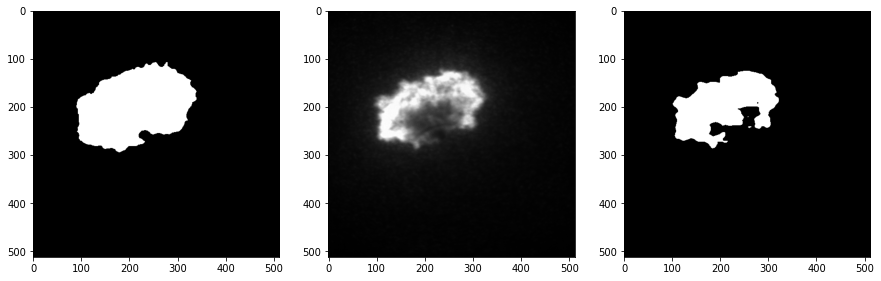

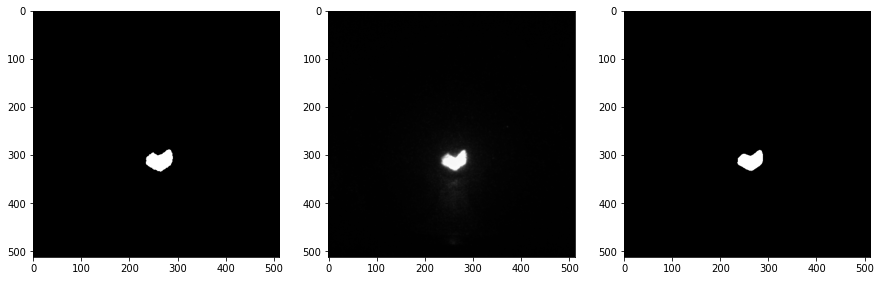

In [ ]:
x,y = next(iter(test_dataloader))

model.eval()
model.to('cuda')
with torch.no_grad():
    out = model.forward(x.to('cuda'))

outs = torch.argmax(out.to('cpu'), dim=1)

for k in range(batch_size):
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(y[k,0], cmap='gray')

    plt.subplot(1,3,2)
    plt.imshow(x[k,0], cmap='gray')

    plt.subplot(1,3,3)
    plt.imshow(np.array(outs[k]), cmap='gray')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


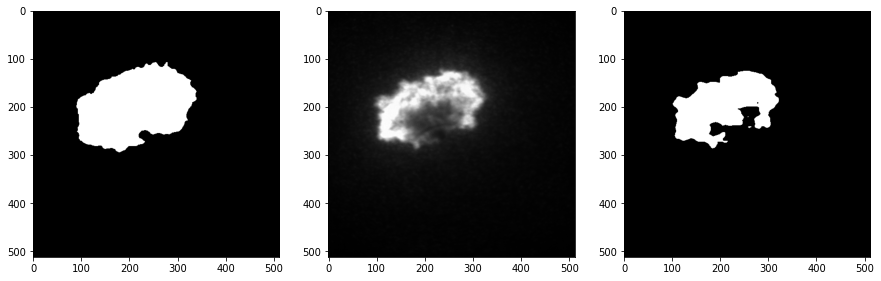

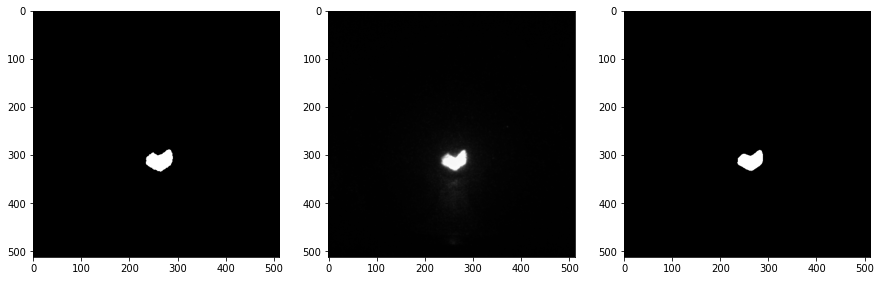

In [ ]:
x,y = next(iter(test_dataloader))

model.eval()
model.to('cuda')
with torch.no_grad():
    out = model.forward(x.to('cuda'))

outs = torch.argmax(out.to('cpu'), dim=1)

for k in range(batch_size):
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(y[k,0], cmap='gray')

    plt.subplot(1,3,2)
    plt.imshow(x[k,0], cmap='gray')

    plt.subplot(1,3,3)
    plt.imshow(np.array(outs[k]), cmap='gray')

# Evaluating

Dice coefficient:

In [ ]:
def dice(x,y):
    eps = 1e-3;
    inter = (x*y).sum()
    return 2*inter/(x.sum() + y.sum() + eps)

Traditional method:

In [ ]:
def otsu(f):
     n = np.product(np.shape(f))
     h = 1.*np.bincount(f.ravel()) / n  
     if len(h) == 1: return 1,1
     x = np.arange(np.product(np.shape(h)))
     w0 = np.cumsum(h)
     w1 = 1 - w0
     eps = 1e-10
     m0 = np.cumsum(x * h) / (w0 + eps)
     mt = m0[-1]
     m1 = (mt - m0[0:-1]*w0[0:-1]) / w1[0:-1]
     sB2 = w0[0:-1] * w1[0:-1] * ((m0[0:-1] - m1)**2)
     t = np.argmax(sB2)
     v = sB2[t]
     st2 = sum((x-mt)**2 * h)
     eta = v / st2
     return t, eta

In [ ]:
def to_255(x):
    xmin,_ = x.min(axis=2, keepdims=True)
    xmin,_ = xmin.min(axis=3, keepdims=True)

    xmax,_ = x.max(axis=2, keepdims=True)
    xmax,_ = xmax.max(axis=3, keepdims=True)

    x = 255*(x-xmin)/(xmax-xmin)

    return x

In [ ]:
model.eval()

model.to('cuda')

img = []
gt = []
out_unet = []

for x,y in test_dataloader:
    x_dnorm = dnorm(x[:,[0],:,:], train_mean, train_std)
    x_255 = to_255(x_dnorm)
    
    img.append(x_255)
    gt.append(y)
    with torch.no_grad():
        out = model.forward(x.to('cuda'))
        out_unet.append(out)

out_unet = torch.vstack(out_unet)
out_unet = torch.argmax(out_unet, dim=1)

img = torch.vstack(img)
gt = torch.vstack(gt)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Calculating traditional segmentation and Dice coefficients:

In [ ]:
out_otsu = []
dice_otsu = []
dice_unet = []

for k in range(len(img)):
    t,_ = otsu(img[k,0].to('cpu'))
    out_otsu.append(img[k,0] > t)

    dice_otsu.append(dice(out_otsu[k], gt[k]))
    dice_unet.append(dice(out_unet[k].to('cpu'), gt[k]))

dice_otsu = np.array(dice_otsu)
dice_unet = np.array(dice_unet)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


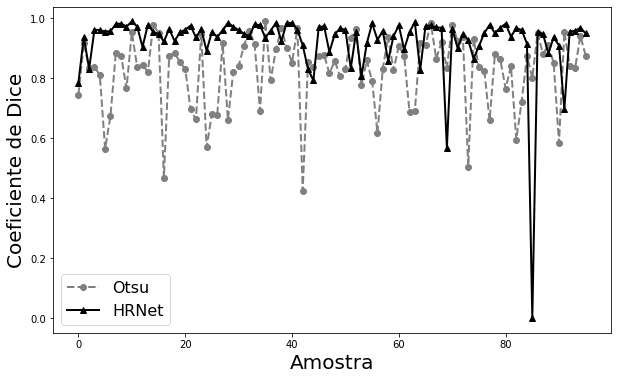

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(dice_otsu, color='gray', linestyle='--', marker='o', linewidth=2)
plt.plot(dice_unet, color='black', marker='^', linewidth=2)
plt.ylabel('Coeficiente de Dice', fontsize=20);
plt.xlabel('Amostra', fontsize=20);
plt.legend(['Otsu', 'HRNet'], fontsize=16);
plt.savefig(f'/content/drive/MyDrive/Doutorado/Disciplinas/[IA376-I] Introdução a Deep Learning/Projeto Final/output_mixed/dice_{size[0]}x{size[1]}_hrnet.eps', format='eps')

In [ ]:
print(np.mean(dice_otsu))
print(np.mean(dice_unet))

0.82695717
0.92383844


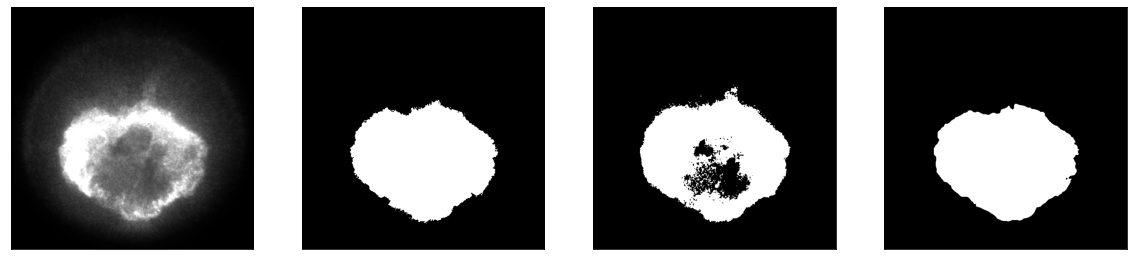

In [ ]:
idx = 8

plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.imshow(img[idx,0], 'gray')
plt.yticks([]);
plt.xticks([]);

plt.subplot(1,4,2)
plt.imshow(gt[idx,0], 'gray')
plt.yticks([]);
plt.xticks([]);

plt.subplot(1,4,3)
plt.imshow(out_otsu[idx], 'gray')
plt.yticks([]);
plt.xticks([]);

plt.subplot(1,4,4)
plt.imshow(out_unet[idx].to('cpu'), 'gray')
plt.yticks([]);
plt.xticks([]);

# Inference time

In [ ]:
from timeit import default_timer as timer

In [ ]:
test_dataloader_inf = DataLoader(test_dataset,
                                batch_size = 1,
                                shuffle = False)

On GPU

In [ ]:
times = []
model.to('cuda')
with torch.no_grad():
    for xt,_ in test_dataloader_inf:
        xt = xt.to('cuda')
        
        start = timer()
        out = model(xt)
        end = timer()

        times.append(end-start)
print(np.mean(times))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


0.007907054520804499


On CPU

In [ ]:
times = []
model.to('cpu')
with torch.no_grad():
    for xt,_ in test_dataloader_inf:        
        start = timer()
        out = model(xt)
        end = timer()
        times.append(end-start)
print(np.mean(times))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


3.445127647968718


# Image generation

In [ ]:
idxs = [12,17,21,50,58]

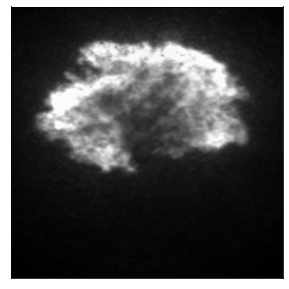

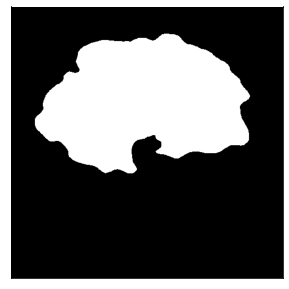

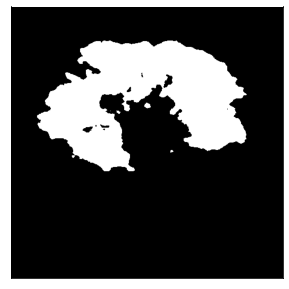

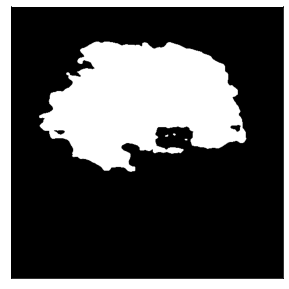

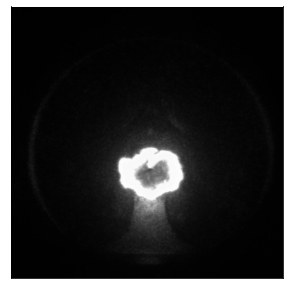

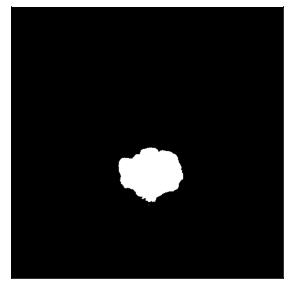

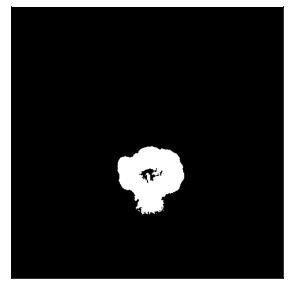

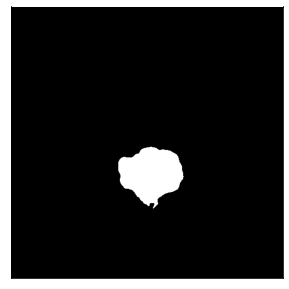

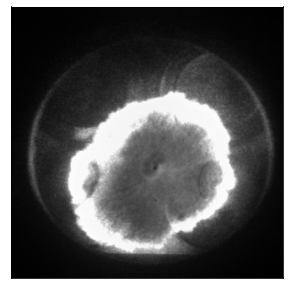

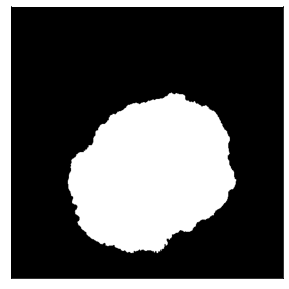

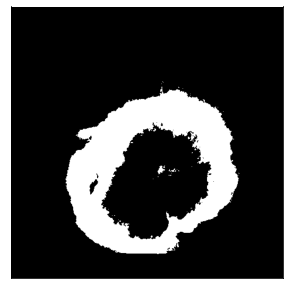

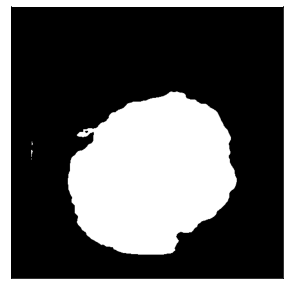

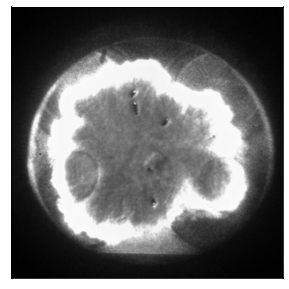

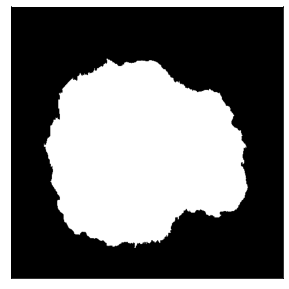

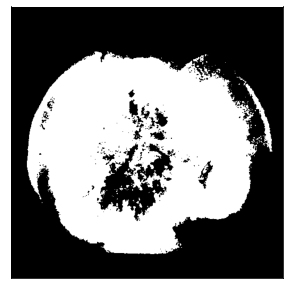

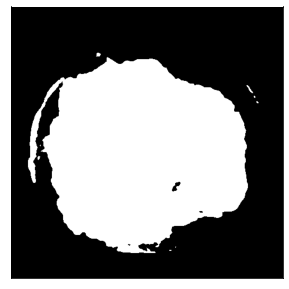

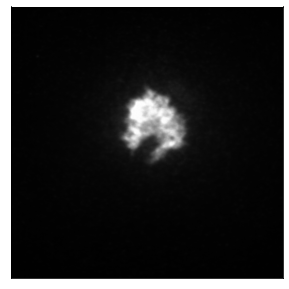

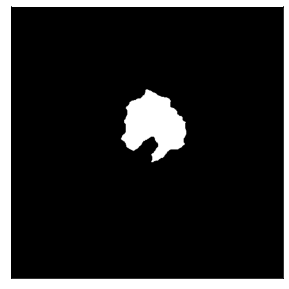

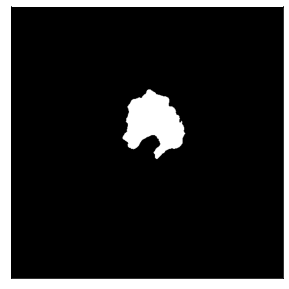

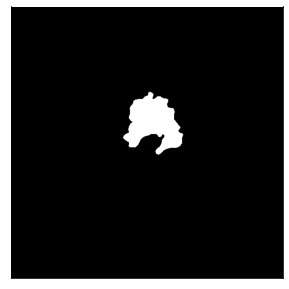

In [ ]:
for idx in idxs:
    plt.figure(figsize=(5,5))
    plt.imshow(img[idx,0], 'gray')
    plt.yticks([]);
    plt.xticks([]);
    plt.savefig(f'/content/drive/MyDrive/Doutorado/Disciplinas/[IA376-I] Introdução a Deep Learning/Projeto Final/output_mixed/original_{size[0]}x{size[1]}_{idx}.eps', format='eps')

    plt.figure(figsize=(5,5))
    plt.imshow(gt[idx,0], 'gray')
    plt.yticks([]);
    plt.xticks([]);
    plt.savefig(f'/content/drive/MyDrive/Doutorado/Disciplinas/[IA376-I] Introdução a Deep Learning/Projeto Final/output_mixed/gt_{size[0]}x{size[1]}_{idx}.eps', format='eps')

    plt.figure(figsize=(5,5))
    plt.imshow(out_otsu[idx], 'gray')
    plt.yticks([]);
    plt.xticks([]);
    plt.savefig(f'/content/drive/MyDrive/Doutorado/Disciplinas/[IA376-I] Introdução a Deep Learning/Projeto Final/output_mixed/otsu_{size[0]}x{size[1]}_{idx}.eps', format='eps')

    plt.figure(figsize=(5,5))
    plt.imshow(out_unet[idx].to('cpu'), 'gray')
    plt.yticks([]);
    plt.xticks([]);
    plt.savefig(f'/content/drive/MyDrive/Doutorado/Disciplinas/[IA376-I] Introdução a Deep Learning/Projeto Final/output_mixed/hrnet_{size[0]}x{size[1]}_{idx}.eps', format='eps')